# Import Libraries
<font size="2" color="black">In this section of the code - we load the Python libraries that are required to execute the code in this Notebook.</font>

In [74]:
import datetime          as dtm
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import os.path

from   matplotlib.backends.backend_pdf import PdfPages
from   sklearn                         import datasets, linear_model

# Import Data File
<font size="2" color="black">In this section of the code - we load the primary data file for this Notebook; and, execute any required cleansing operations.</font>

In [75]:
# Load Data File from /u drive
#str_filename = 'ghost_1FM5K7D82JGA66949_adjust.csv'

# Load data file from /s drive
str_filename = '/s/lguerra5/e2e/test.csv'

df           = pd.read_csv(str_filename, sep=',')
#df           = pd.read_csv(str_filename, sep=',',dtype={"timeend2": object, "trip_end_eng_oil_percent": int, "trip_end_odo_read": int, "vin": object, \
#                                                        "trip_number": int, "oil_change_flag": int, "oil_change_cycle_number": int, "first_ol_pct": int, "first_odometer": int, \
#                                                        "first_ol_date": object})
df           = df.sort_values('trip_number', ascending=False)

# OIL CHANGE CYCLE NUMBER SHIFT - dont do if data doesnt have an oil change
max_oil_change_cycle            = int(df['oil_change_cycle_number'].max())
df['oil_change_detection']      = 0
df['oil_change_detection']      = df['oil_change_cycle_number'].diff().abs()
df['oil_percent_diff']          = 0
df['oil_percent_diff']          = df['trip_end_eng_oil_percent'].diff().where(df['oil_change_detection'] == 1).abs()
df['oil_change_diff']           = max_oil_change_cycle - df['oil_change_cycle_number']
df                              = df.fillna(0)
df['oil_percent_diff_cumsum']   = df.oil_percent_diff.cumsum()
df['oil_percent_updated']       = df['trip_end_eng_oil_percent'] + df['oil_percent_diff_cumsum'] + df['oil_change_diff']
drop_columns                    = ['oil_change_detection', 'oil_percent_diff', 'oil_change_diff','oil_percent_diff_cumsum', 'trip_end_eng_oil_percent']
#df                              = df.query('trip_end_eng_oil_percent <= 75')
df                              = df.drop(columns=drop_columns)
df                              = df.rename(columns={'oil_percent_updated': 'trip_end_eng_oil_percent'})
#df                              = df[['oil_change_cycle_number', 'trip_number', 'timeend2', 'trip_end_eng_oil_percent', 'trip_end_odo_read', 'vin']]

# Add Column 'date' in Correct Format
df.insert(5, "date", pd.to_datetime(df.timeend2).astype('datetime64[ns]'))

df.head()

timeend2  trip_end_odo_read                 vin  trip_number  \
394  7/17/2020            4432.50  WF0NXXGCHNJL14002           395   
393  7/17/2020            4421.25  WF0NXXGCHNJL14002           394   
392  7/16/2020            4410.00  WF0NXXGCHNJL14002           393   
391  7/16/2020            4398.75  WF0NXXGCHNJL14002           392   
390  7/16/2020            4387.50  WF0NXXGCHNJL14002           391   

     oil_change_cycle_number       date  first_ol_pct  first_odometer  \
394                        0 2020-07-17           100               0   
393                        0 2020-07-17           100               0   
392                        0 2020-07-16           100               0   
391                        0 2020-07-16           100               0   
390                        0 2020-07-16           100               0   

    first_ol_date  trip_end_eng_oil_percent  
394      3/8/2020                      71.0  
393      3/8/2020                      71.0  
392      3/8/2020                      71.0  
391      3/8/2020                      71.0  
390      3/8/2020                      71.0

In [76]:
min(df.date)

Timestamp('2020-03-08 00:00:00')

In [77]:
len(df)

395

# Plot Oil Life % vs. Time
<font size="2" color="black">In this section of the code - we plot the {<b>Oil Life %</b>} values against {<b>Time</b>} for a single Oil Life % interval, as a data exploration step.</font>

Text(0, 0.5, 'Oil Life %')

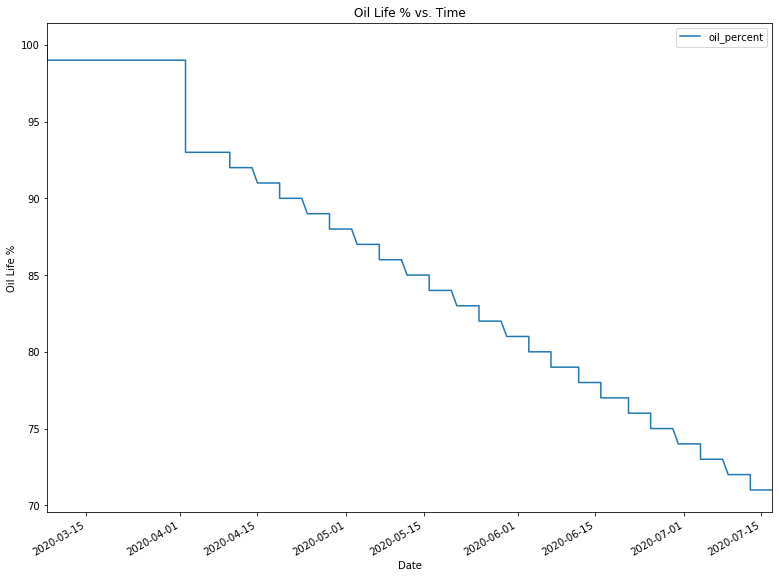

In [78]:
# Instantiate DataFrames
df_interval                = pd.DataFrame()
df_interval_first          = pd.DataFrame()

# Select Pertinent Fields from df
df_interval["trip_number"] = pd.Series(df.trip_number)
df_interval["date"]        = pd.Series(df.date)
df_interval["odometer"]    = pd.Series(df.trip_end_odo_read)
df_interval["oil_percent"] = pd.Series(df.trip_end_eng_oil_percent)
df_interval                = df_interval.sort_values('trip_number')

# Select Subset of Rows from df_interval
df_interval_first          = df_interval[(df_interval['trip_number'] <= 100000)]

# Plot {Oil Life %} vs. {Time}
ax                         = df_interval_first.plot(x='date', y='oil_percent', title='Oil Life % vs. Time', figsize=(13, 10))
ax.set_xlabel("Date")
ax.set_ylabel("Oil Life %")

# Plot Odometer vs. Time
<font size="2" color="black">In this section of the code - we plot the {<b>Odometer</b>} values against {<b>Time</b>} for a single Oil Life % interval, as a data exploration step.</font>

Text(0, 0.5, 'Odometer (km)')

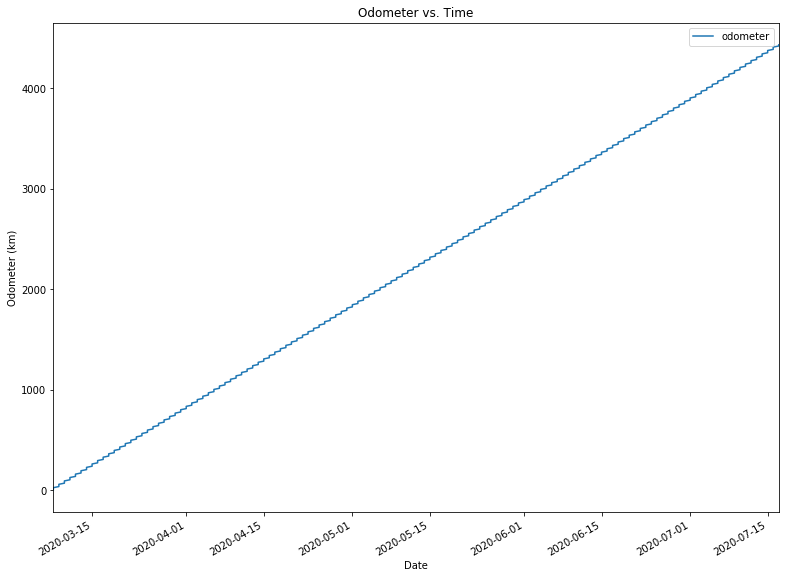

In [80]:
# Plot {Odometer} vs. {Time}
ax  = df_interval_first.plot(x='date', y='odometer', title='Odometer vs. Time', figsize=(13, 10))
ax.set_xlabel("Date")
ax.set_ylabel("Odometer (km)")

# Predict Date of Oil Change
<font size="2" color="black">In this section of the code - we run an exponentially-weighted Linear Regression on the data for a single interval to predict the date wherein {<b>Oil Life %</b>} becomes zero; and thus, wherein an Oil Change is required.  This is the foundational algorithm for the Oil Change Prediction prognostic. </font>

In [81]:
# Initialize Parameters
w_exp_seed      = 1.05                          # Exponential Weight: Seed

#in case we want to set the start date to a different date
#start_date  = dtm.datetime(2019, 5, 28)

#set start date to TODAY
start_date      = dtm.datetime.utcnow().date()  # Today's Date
start_date_np   = np.datetime64(start_date)     # Today's Date

# Initialize Variables
w               = np.zeros(1)                   # Linear Regression: Slope
b               = np.zeros(1)                   # Linear Regression: Bias

In [82]:
# Import Oil Life % Values into numpy Array
oil_percent     = df_interval_first.oil_percent.values
oil_percent     = oil_percent.reshape(-1,1)

In [83]:
# Compute Time Delta Between df_interval_first and start_date (in Days)
t               = (df_interval_first.date - start_date_np).dt.days.values
t               = t.reshape(-1, 1)

In [84]:
print(t)
print(t.reshape(-1))

[[-50]
 [-50]
 [-50]
 [-49]
 [-49]
 [-49]
 [-48]
 [-48]
 [-48]
 [-47]
 [-47]
 [-47]
 [-46]
 [-46]
 [-46]
 [-45]
 [-45]
 [-45]
 [-44]
 [-44]
 [-44]
 [-43]
 [-43]
 [-43]
 [-42]
 [-42]
 [-42]
 [-41]
 [-41]
 [-41]
 [-40]
 [-40]
 [-40]
 [-39]
 [-39]
 [-39]
 [-38]
 [-38]
 [-38]
 [-37]
 [-37]
 [-37]
 [-36]
 [-36]
 [-36]
 [-35]
 [-35]
 [-35]
 [-34]
 [-34]
 [-34]
 [-33]
 [-33]
 [-33]
 [-32]
 [-32]
 [-32]
 [-31]
 [-31]
 [-31]
 [-30]
 [-30]
 [-30]
 [-29]
 [-29]
 [-29]
 [-28]
 [-28]
 [-28]
 [-27]
 [-27]
 [-27]
 [-26]
 [-26]
 [-26]
 [-25]
 [-25]
 [-25]
 [-24]
 [-24]
 [-24]
 [-23]
 [-23]
 [-23]
 [-22]
 [-22]
 [-22]
 [-21]
 [-21]
 [-21]
 [-20]
 [-20]
 [-20]
 [-19]
 [-19]
 [-19]
 [-18]
 [-18]
 [-18]
 [-17]
 [-17]
 [-17]
 [-16]
 [-16]
 [-16]
 [-15]
 [-15]
 [-15]
 [-14]
 [-14]
 [-14]
 [-13]
 [-13]
 [-13]
 [-12]
 [-12]
 [-12]
 [-11]
 [-11]
 [-11]
 [-10]
 [-10]
 [-10]
 [ -9]
 [ -9]
 [ -9]
 [ -8]
 [ -8]
 [ -8]
 [ -7]
 [ -7]
 [ -7]
 [ -6]
 [ -6]
 [ -6]
 [ -5]
 [ -5]
 [ -5]
 [ -4]
 [ -4]
 [ -4]
 [ -3]
 [ -3]

In [85]:
# Compute Exponential Weighting to Ensure Recent Data Is More Important
w_exp           = [np.power(w_exp_seed, p) for p in t.reshape(-1)]
print(w_exp)

[0.08720372697238048, 0.08720372697238048, 0.08720372697238048, 0.0915639133209995, 0.0915639133209995, 0.0915639133209995, 0.09614210898704947, 0.09614210898704947, 0.09614210898704947, 0.10094921443640195, 0.10094921443640195, 0.10094921443640195, 0.10599667515822206, 0.10599667515822206, 0.10599667515822206, 0.11129650891613317, 0.11129650891613317, 0.11129650891613317, 0.11686133436193984, 0.11686133436193984, 0.11686133436193984, 0.12270440108003683, 0.12270440108003683, 0.12270440108003683, 0.12883962113403868, 0.12883962113403868, 0.12883962113403868, 0.13528160219074062, 0.13528160219074062, 0.13528160219074062, 0.14204568230027764, 0.14204568230027764, 0.14204568230027764, 0.14914796641529154, 0.14914796641529154, 0.14914796641529154, 0.15660536473605613, 0.15660536473605613, 0.15660536473605613, 0.16443563297285893, 0.16443563297285893, 0.16443563297285893, 0.1726574146215019, 0.1726574146215019, 0.1726574146215019, 0.181290285352577, 0.181290285352577, 0.181290285352577, 0.1

In [86]:
w_exp           = np.array(w_exp / sum(w_exp))
print(w_exp)

[2.70716661e-05 2.70716661e-05 2.70716661e-05 2.84252494e-05
 2.84252494e-05 2.84252494e-05 2.98465119e-05 2.98465119e-05
 2.98465119e-05 3.13388374e-05 3.13388374e-05 3.13388374e-05
 3.29057793e-05 3.29057793e-05 3.29057793e-05 3.45510683e-05
 3.45510683e-05 3.45510683e-05 3.62786217e-05 3.62786217e-05
 3.62786217e-05 3.80925528e-05 3.80925528e-05 3.80925528e-05
 3.99971804e-05 3.99971804e-05 3.99971804e-05 4.19970394e-05
 4.19970394e-05 4.19970394e-05 4.40968914e-05 4.40968914e-05
 4.40968914e-05 4.63017360e-05 4.63017360e-05 4.63017360e-05
 4.86168228e-05 4.86168228e-05 4.86168228e-05 5.10476639e-05
 5.10476639e-05 5.10476639e-05 5.36000471e-05 5.36000471e-05
 5.36000471e-05 5.62800495e-05 5.62800495e-05 5.62800495e-05
 5.90940520e-05 5.90940520e-05 5.90940520e-05 6.20487546e-05
 6.20487546e-05 6.20487546e-05 6.51511923e-05 6.51511923e-05
 6.51511923e-05 6.84087519e-05 6.84087519e-05 6.84087519e-05
 7.18291895e-05 7.18291895e-05 7.18291895e-05 7.54206490e-05
 7.54206490e-05 7.542064

In [87]:
# Compute Linear Regression Model
regr_oil        = linear_model.LinearRegression(fit_intercept=True)
regr_oil.fit(oil_percent, t, sample_weight=w_exp)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [88]:
#upper limit values (from table or just 16000 km/365 days for US vehicles) - Change for EU vehicles
vehicle_odometer_limit = 15000
vehicle_date_limit = 365

In [95]:
# If Regression Line Is Nearly Flat, Set b = 365; (oil life will be 0% in 365 days);
# Else, Compute d via the Linear Regression Model
if regr_oil.coef_[0] <= (-0.01*vehicle_date_limit):
    b[0]    = vehicle_date_limit    
else:
    b[0]    = regr_oil.intercept_[0]

w[0]        = regr_oil.coef_[0]
w[0], b[0]

(-4.418844013219653, 365.0)

In [96]:
# Return Predicted Date for Next Oil Change
next_oil_change = start_date + dtm.timedelta(days=b[0])
next_oil_change

datetime.date(2021, 4, 27)

In [97]:
# Return r-Squared Value for Oil Model
r_squared       = regr_oil.score(oil_percent, t)
r_squared

0.9852217342267953

In [98]:
# Return Number of Samples
num_samples     = oil_percent.size
num_samples

395

In [99]:
#*************************************************************
#************** computed weighted R squared ****************** 
#*************************************************************
t_pred = regr_oil.predict(oil_percent)
weighted_mean = np.average(t,weights = w_exp.reshape([-1,1]))
SST = np.dot(w_exp,np.square(t-weighted_mean))
SSE = np.dot(w_exp,np.square(t-t_pred))
if SST!=0:
    weighted_r_squared = np.asscalar(1-SSE/SST)
else:
    weighted_r_squared = 12345.0
#*************************************************************
#************************************************************* 
#*************************************************************

In [100]:
# Return weighted r-Squared Value
weighted_r_squared

0.9941406219603364

# Predict Odometer Reading at Oil Change
<font size="2" color="black">In this section of the code - we run an exponentially-weighted Linear Regression on the data for a single interval to translate the Predicated Date ouput in the prior section to a Predicted Odometer Reading; and, vice versa.  This is another foundational algorithm for the Oil Change Prediction prognostic. </font>

In [101]:
# Import Odometer Values into numpy Array
odometer            = df_interval_first.odometer.values
odometer            = odometer.reshape(-1,1)

In [102]:
# Compute Linear Regression Model
regr_odometer       = linear_model.LinearRegression(fit_intercept=True)
regr_odometer.fit(odometer, t, sample_weight=w_exp)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [118]:
# Return r-Squared Value for Odo Model
odo_r_squared       = regr_odometer.score(odometer, t)
odo_r_squared

0.9999487821835963

In [103]:
# Compute the Number of Days to Next Oil Change
# NOTE: You Can Choose Any Value of next_oil_days to Determine Prediction of Odometer Reading at that Value
# next_oil_days       = (next_oil_change - start_date).days
next_oil_days       = b[0]
next_oil_days

365.0

In [104]:
# Return Predicted Odometer for Next Oil Change
#next_oil_odometer   = (next_oil_days - regr_odometer.intercept_) / regr_odometer.coef_
#next_oil_odometer[0][0]

In [105]:
# Return Number of Days to Next Oil Change from Odometer Reading
#next_oil_days       = (next_oil_odometer * regr_odometer.coef_) + regr_odometer.intercept_
#next_oil_days[0][0]

In [107]:
# Odo Model Parameters
odo_slope = regr_odometer.coef_
odo_intercept = regr_odometer.intercept_

In [108]:
print(odo_intercept[0])
print(odo_slope[0][0])

-50.33783656373827
0.02963226394769326


### Calculate Odometer limits 

In [109]:
# Odometer slopes very close to zero will result in an undefined integer value when the
# predicted odometer is calculated (division by zero)
if odo_slope < 0.0001:
    next_oil_odometer = -1
else:
    # num_days_to_when_odo_ready_for_oil_change = num_days_till_zero_oil_life = oil_intercept
    next_oil_odometer = (next_oil_days - odo_intercept) / odo_slope
    next_oil_odometer = next_oil_odometer[0][0]

# Calculate upper limits for odometer & date of predicted oil life
pred_date_limit = next_oil_change #predicted oil change date
pred_odo_limit_if_under_max_km = int(next_oil_odometer)
pred_odo_limit_if_above_max_km = int(next_oil_odometer)

first_oil_life_date = df['first_ol_date'].values[0]
first_oil_life_percent = df['first_ol_pct'].values[0]
first_oil_life_percent = float(first_oil_life_percent)
first_odometer = df['first_odometer'].values[0]
first_odometer = int(first_odometer)

if max_oil_change_cycle == 0:
    first_oil_life_percent = first_oil_life_percent / 100
    max_possible_days_till_oil_change = int(round(first_oil_life_percent * vehicle_date_limit))
    pred_date_limit = pd.to_datetime(first_oil_life_date) + dtm.timedelta(days=max_possible_days_till_oil_change)

    max_possible_km_till_oil_change_under = int(round(first_oil_life_percent * (vehicle_odometer_limit + 500)))
    pred_odo_limit_if_under_max_km = first_odometer + max_possible_km_till_oil_change_under

    max_possible_km_till_oil_change_above = int(round(first_oil_life_percent * vehicle_odometer_limit))
    pred_odo_limit_if_above_max_km = first_odometer + max_possible_km_till_oil_change_above

elif max_oil_change_cycle >= 1:
    pred_date_limit = pd.to_datetime(first_oil_life_date) + dtm.timedelta(days=vehicle_date_limit)
    pred_odo_limit_if_under_max_km = first_odometer + vehicle_odometer_limit
    pred_odo_limit_if_above_max_km = first_odometer + vehicle_odometer_limit

### Next Oil Change Predictions (Model Output)

In [110]:
print(next_oil_odometer)
print(next_oil_change)

14016.405810129485
2021-04-27


In [111]:
print(pred_date_limit)
print(pred_odo_limit_if_under_max_km)
print(pred_odo_limit_if_above_max_km)

2021-03-08 00:00:00
15500
15000


In [112]:
print(pred_date_limit.date())

2021-03-08


In [113]:
max_oil_change_cycle

0

## Check Odo and Date Limits for Prediction
### Clip prediction output to set time/odo limit if limits are exceeded by model predictions

In [114]:
if next_oil_change > pred_date_limit:
    next_oil_change =  pred_date_limit
    
if (next_oil_odometer > pred_odo_limit_if_under_max_km) or (next_oil_odometer > pred_odo_limit_if_above_max_km):
    next_oil_odometer = pred_odo_limit_if_under_max_km

In [115]:
print(next_oil_odometer)
print(next_oil_change)

14016.405810129485
2021-03-08 00:00:00


# Plot Oil Life % vs. Time | w/ Regression
<font size="2" color="black">In this section of the code - we plot the {<b>Oil Life %</b>} values against {<b>Time</b>} for a single Oil Life % interval, with predicted regression.</font>

In [ ]:
# Derive Datetimes for Raw Data
td          = pd.to_datetime(np.array(df_interval_first['date'])).date.tolist()

# Derive Datetimes for Regression Fit
y           = regr_oil.predict(oil_percent)
yd          = [start_date + dtm.timedelta(days=int(d)) for d in y.reshape(-1)]
yd          = np.array(yd).reshape(-1,1)

In [ ]:
# Initialize Parameters
colors      = ['#e24638','#e07f3a','#e2ca3d','#68e03c','#3ce0da','#3e49e0','#d83ee0','#e54082']
markers     = ['o','v','8','s','*','^','D','x']

In [ ]:
# Initialize Figure
plt.figure(figsize=(13,10))

# Plot {Raw Data, Regression Fit} onto Figure
plt.scatter(td, oil_percent, marker=markers[1], label = '1FMCU0...', edgecolors='face')
plt.plot(   yd, oil_percent, ls="--")

# Set Remainig Parameters for Graph
plt.xlabel('Date')
plt.ylabel('Oil Life %')

plt.xticks(rotation='vertical')
plt.xticks(fontsize=15)
plt.tick_params(labelsize=20)
                
plt.xlim([td[0], td[-1]])
plt.legend(loc=2)

# Plot Odometer vs. Time | w/ Regression
<font size="2" color="black">In this section of the code - we plot the {<b>Odometer</b>} values against {<b>Time</b>} for a single Oil Life % interval, with predicted regression.</font>

In [ ]:
# Derive Datetimes for Regression Fit
z           = regr_odometer.predict(odometer)
zd          = [start_date + dtm.timedelta(days=int(d)) for d in z.reshape(-1)]
zd          = np.array(zd).reshape(-1,1)

In [ ]:
# Initialize Figure
plt.figure(figsize=(13,10))

plt.scatter(odometer, td, color=colors[1], marker=markers[1], label = '1FMCU0...', edgecolors='face')
plt.plot(   odometer, zd, ls="--",color=colors[1])

# Set Remainig Parameters for Graph
plt.xlabel('Odometer (km)')
plt.ylabel('Date')

plt.xticks(rotation='vertical')
plt.xticks(fontsize=15)
plt.tick_params(labelsize=20)
                
plt.ylim([td[0], td[-1]])
plt.legend(loc=2)                